In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.offline as py
from plotly.graph_objs import Scatter, Layout
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import sklearn as sk
import plotly.express as px
from dash import Dash, dcc, html, Input, Output  # pip install dash (version 2.0.0 or higher)
from flask import Flask
import dash_bootstrap_components as dbc
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from plotly.subplots import make_subplots
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [52]:
names = ['ID', 'Age', 'Gender', 'Education', 'Country', 'Ethnicity', 'Neuroticism', 'Extraversion', 'Openness', 'Agreeableness', 'Conscientiousness', 'Impulsiveness', 'Sensation_seeking', 'Alcohol', 'Amphetamine', 'Amyl_nitrite', 'Benzodiazepine', 'Caffeine', 'Cannabis', 'Chocolate', 'Cocaine', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine', 'Legal_highs', 'LSD', 'Methadone', 'Mushrooms', 'Nicotine', 'Semeron', 'VSA']
df = pd.read_csv('drug_consumption.data',delimiter=',', names=names)

In [3]:
#CL0 to CL6 correspond to
#"Never Used", "Used over a Decade Ago", "Used in Last Decade", "Used in Last Year", "Used in Last Month", "Used in Last Week", and "Used in Last Day".


# dictionnaire pour traduire les valeurs
traduction={-0.95197: "18-24 ans", -0.07854 :"25-34",  0.49788 :"35-44",1.09449 :"45-54", 1.82213:" 55-64", 2.59171: "65+"}
traduction[0.48246]="Female"
traduction[-0.48246]= "Male"
traduction[-2.43591 ]="Left school before 16 years"
traduction[-1.73790]= "Left school at 16 years"
traduction[-1.43719 ]="Left school at 17 years"
traduction[-1.22751]= "Left school at 18 years"
traduction[-0.61113]="Some college or university, no certificate or degree"
traduction[-0.05921]= "Professional certificate/ diploma "
traduction[0.45468]="University degree  "
traduction[1.16365]= "Masters degree "
traduction[1.98437]="Doctorate degree "

traduction[-0.09765 ]="Australia"
traduction[0.24923]= "Canada"
traduction[-0.46841]= "New Zealand "
traduction[-0.28519]= "Other "
traduction[0.21128]= "Republic of Ireland"
traduction[0.96082]= " UK "
traduction[-0.57009]= "USA"

traduction[-0.50212]="Asian"
traduction[-1.10702]="Black"
traduction[1.90725]="Mixed-Black/Asian"
traduction[0.12600]="Mixed-White/Asian"
traduction[-0.22166]="Mixed-White/Black"
traduction[0.11440]="Other "
traduction[-0.31685]="White"

traduction["CL0"]="Never Used"
traduction["CL1"]="Used over a Decade Ago"
traduction["CL2"]="Used in Last Decade"
traduction["CL3"]="Used in Last Year "
traduction["CL4"]="Used in Last Month"
traduction["CL5"]="Used in Last Week"
traduction["CL6"]="Used in Last Day"
        

In [53]:
df=df.set_index('ID')

## Visualisation 

In [5]:
liars = df[df['Semeron']!='CL0']
#df.drop(df[df['Semeron']!='CL0'].index, inplace=True)
#df.drop('Semeron', axis=1, inplace=True)

Semer is a fictional drug, so everyone that said they ever used it are lying. So we delete every lying people and delete this row.

In [6]:
drugs = [ 'Alcohol', 'Amphetamine', 'Amyl_nitrite', 'Benzodiazepine', 'Caffeine', 'Cannabis', 
         'Chocolate', 'Cocaine', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine', 'Legal_highs', 'LSD', 
         'Methadone', 'Mushrooms', 'Nicotine', 'VSA']

def change(a):
    if a in ['CL6', 'CL5', 'CL4']:
        return 2 #Regular users
    elif a in ['CL1', 'CL2', 'CL3']:
        return 1 #Occasional users
    elif a=='CL0':
        return 0 #Never used
    return a

df2=df.copy() #for a better display on the views
for drug in drugs:
    liars[drug]=liars[drug].apply(change)
    df2[drug]=df2[drug].apply(change)
    
def getDrugScore(drugName):
    return df2[[drugName, 'Neuroticism', 'Extraversion', 'Openness', 'Agreeableness', 'Conscientiousness', 'Impulsiveness', 'Sensation_seeking']]

In [7]:
pie1=(liars[drugs]>0).sum()
pie2=(df2[drugs]>0).sum()
fig = make_subplots(rows=1, cols=2,
                    specs=[[{'type': 'pie'}, {'type': 'pie'}]],
                    subplot_titles=['Drug repartition for liars', 'Drug repartition for people'])
fig.add_trace(go.Pie(values=pie1.values,labels=pie1.index, name=""), row=1, col=1)
fig.add_trace(go.Pie(values=pie2.values,labels=pie2.index, name=""), row=1, col=2)
fig.show()

First of all, there are only 8 people that lied, which is very little to be compared to the rest of the dataset, so we can't take these results very seriously. However, it seems that the percentage of people that of LSD and mushrooms has a increased where these of alcohol has decreased by a lot on the liars' graph. From the data at our disposal, we can say that people perfer telling they took drugs than alcohol.

In [8]:
fig = px.bar(df2[drugs].apply(lambda x: x.value_counts()).T.rename(columns={0:'Never Used',1:'Occasional', 2:'Regular'}),
       barmode='group',
       title='Distribution of the number of users for each drug'
      )
fig.update_layout(title_x=0.5)
fig.show()

From this graph, we can see that there is a huge part of regular users for 'socially accepted' drugs like alcohol, caffeine or chocolate but it isn't the case for all since nicotine has a large part of occasionally users and people who never used it.
It seems that there is the same proportion of people that uses occasionally drugs like amphetamine, cannabis, coke or LSD. There could be a correlation.

Columns the most correlated are Impulsive and sensation-seeking, so there is a correlation between the fact of seeking sensations and being impulsive.
The neuroticism and extraversion are very negatively correlated, so when someone is more neurotic, he tend to be also less extrovert.

In [9]:
from plotly.subplots import make_subplots

fig = make_subplots(rows=len(drugs), cols=1, subplot_titles=drugs)

for i, drug in enumerate(drugs):
    data = getDrugScore(drug)
    subplot = px.bar(data.groupby(drug).mean().T.rename(columns={0:"Occasional", 1:'Regular'}), barmode='group')
    for trace in range(len(subplot["data"])):
        fig.append_trace(subplot["data"][trace], row=i+1, col=1)
    

fig.update_layout(height=200*len(drugs), width=600, title_text="Mean score for each drug")
fig.show()

For most drugs (except for chocolate, alcohol), occasional and most importantly regular consumers are more implulsive, seek more sensations and are more open to new experiences since their average score is higher than occasional consumers. However, they became less agreable and cautious.

In [10]:
fig = make_subplots(rows=len(drugs), cols=2, 
                    specs=[[{'type': 'pie'}, {'type': 'pie'}]]*len(drugs), #specify the type of each subplot
                    subplot_titles=[f'{drug} -{a}' for drug in drugs for a in ['Man', 'Woman']] #add a title to each subplot
                   )

for i, drug in enumerate(drugs):

    data1=df2[df2['Gender']==0.48246].replace(traduction)[drug].value_counts().rename(index={0:'Occasional', 1:'Regular'})
    #count each value (0/1) for each drug, filtered by gender
    fig.append_trace(
        go.Pie(values=data1.values, labels=data1.index, name=""), #name="" : prevent from trace X to appear in the hover
        row=i+1, col=1
    )
    
    data2=df2[df2['Gender']==-0.48246].replace(traduction)[drug].value_counts().rename(index={0:'Occasional', 1:'Regular'})
    fig.append_trace(
        go.Pie(values=data2.values, labels=data2.index, name=""),
        row=i+1, col=2
    )

fig.update_layout(height=300*len(drugs), width=700, title_text='Gender repartition for each drug', title_x=0.5) #title_x : center the title
for annotation in fig['layout']['annotations']: 
    annotation['borderpad']=10 #put every subplot title higher to prevent overlapping with percentages
fig.show()

About alcohol, the repartition is the nearly the same for both genders.
It seems that women tend to be more regular and occasional users than men on hard drugs like ecstasy, heroin, LSD.
About nicotine, women are more regular users and men more occasional than women.
Most of the women are regular users of cannabis and a third are occasional ones whereas the repartition for men is more balanced with nearly one third for each. Those results can be explained by the age of the people where nearly the half is between 18 and 34 years.

In [11]:
educ = df2['Education'].map(traduction).value_counts()
fig=go.Figure()
fig.add_trace(go.Pie(values=np.array(educ.values), labels=np.array(educ.index)))
fig.update_layout(title='Education level repartition of the people', title_x=0.19)
fig.show()

Since nearly a third of the people have an age between 18 and 24 years, the results aren't very surprising. The age distribution isn't balanced, so it impacts the education distribution. It is hard to talk about education level because the age will biased the results

In [12]:
scores = ['Neuroticism', 'Extraversion', 'Openness', 'Agreeableness', 'Conscientiousness', 'Impulsiveness', 'Sensation_seeking']

data = pd.DataFrame()

for drug in drugs:
    # Calculate the mean for each score for the current drug
    data = pd.concat([data, df2[df2[drug] > 0][scores].mean().to_frame().T])

# Add a 'Drug' column to the DataFrame
data['Drug'] = drugs

# Reorder the columns to have 'Drug' as the first column
data = data[['Drug'] + scores]

In [13]:
fig = px.bar(data, x='Drug', y=scores, title='Mean Scores for Each Drug',
             labels={'value': 'Mean Score', 'variable': 'Score'},
             template='plotly_dark', barmode='group')
fig.show()

(You can hide the view of some curves by clicking on them on the legend)
The people take takes Ecstasy, Meth or Crack have higher a more neurotic mood on average. So we can say that if a drug user have a high neuroticism, the probability that it uses these drugs is higher too.
It is the same for more extrovert users than the average, they are more likely to consume Amphethamines, Ketamine or Ecstasy.
People who are very open to new experiences have a higher probabilities to be consumers of Legalh, Heroin or LSD if they are drug consumers.
About agreableness and conscientiousness, with a higher score than average, a drug user is more likely to be a consumer of Alcohol, Caffein, Chcoloate, Nicotine or Cannabis.
Impusive drug users are more likely to be consumers of Heroin, Crack or Meth.
Those who are seeking more sensation than average and are drug users have higher probabilities to be Heroin, Meth or Ketamine consumers.

# Machine Learning

In [14]:
def change(a):
    if a in ['CL6', 'CL5', 'CL4']:
        return 1
    elif a in ['CL0', 'CL1', 'CL2', 'CL3']:
        return 0
    return a

dff= df.applymap(change)
drug_columns = ['Ecstasy', 'Heroin', 'Ketamine', 'Legal_highs','LSD', 
                'Methadone', 'Mushrooms', 'Nicotine', 'Semeron', 'VSA']
X = dff.drop(drug_columns, axis=1)
y = dff[drug_columns]

numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

if len(numeric_cols) == 0:
    raise ValueError("No numeric columns found. Check your DataFrame.")

scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X[numeric_cols])

encoder = OneHotEncoder()
X_categorical_encoded = encoder.fit_transform(X[categorical_cols]).toarray()

X_processed = np.concatenate([X_numeric_scaled, X_categorical_encoded], axis=1)

X_tensor = torch.tensor(X_processed, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32)

dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [15]:
import torch.nn as nn
import torch.nn.functional as F

class DrugUseNet(nn.Module):
    def __init__(self, num_features):
        super(DrugUseNet, self).__init__()
        self.fc1 = nn.Linear(num_features, 128) 
        self.fc2 = nn.Linear(128, 64)           
        self.fc3 = nn.Linear(64, len(drug_columns)) 

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

model = DrugUseNet(X_tensor.shape[1])

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

epochs = 25

for epoch in range(epochs):
    for inputs, targets in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

Epoch 1/25, Loss: 0.3202626705169678
Epoch 2/25, Loss: 0.2769503891468048
Epoch 3/25, Loss: 0.2166120707988739
Epoch 4/25, Loss: 0.21626704931259155
Epoch 5/25, Loss: 0.1873520016670227
Epoch 6/25, Loss: 0.2011941522359848
Epoch 7/25, Loss: 0.15427398681640625
Epoch 8/25, Loss: 0.18062810599803925
Epoch 9/25, Loss: 0.1667495220899582
Epoch 10/25, Loss: 0.23778270184993744
Epoch 11/25, Loss: 0.2228361964225769
Epoch 12/25, Loss: 0.17488224804401398
Epoch 13/25, Loss: 0.22014665603637695
Epoch 14/25, Loss: 0.1724269837141037
Epoch 15/25, Loss: 0.1656201332807541
Epoch 16/25, Loss: 0.1811993569135666
Epoch 17/25, Loss: 0.2249167561531067
Epoch 18/25, Loss: 0.26772308349609375
Epoch 19/25, Loss: 0.18201512098312378
Epoch 20/25, Loss: 0.17823652923107147
Epoch 21/25, Loss: 0.1547638177871704
Epoch 22/25, Loss: 0.19449405372142792
Epoch 23/25, Loss: 0.23973578214645386
Epoch 24/25, Loss: 0.12364478409290314
Epoch 25/25, Loss: 0.21217453479766846


Epoch 1/25, Loss: 0.18471309542655945
Epoch 2/25, Loss: 0.2230062335729599
Epoch 3/25, Loss: 0.17943690717220306
Epoch 4/25, Loss: 0.19112028181552887
Epoch 5/25, Loss: 0.1247853934764862
Epoch 6/25, Loss: 0.13613520562648773
Epoch 7/25, Loss: 0.18839503824710846
Epoch 8/25, Loss: 0.173501119017601
Epoch 9/25, Loss: 0.19640928506851196
Epoch 10/25, Loss: 0.21294817328453064
Epoch 11/25, Loss: 0.13637976348400116
Epoch 12/25, Loss: 0.17834721505641937
Epoch 13/25, Loss: 0.15400588512420654
Epoch 14/25, Loss: 0.2067839652299881
Epoch 15/25, Loss: 0.1429016888141632
Epoch 16/25, Loss: 0.16310685873031616
Epoch 17/25, Loss: 0.13005849719047546
Epoch 18/25, Loss: 0.22309738397598267
Epoch 19/25, Loss: 0.18263959884643555
Epoch 20/25, Loss: 0.1504240781068802
Epoch 21/25, Loss: 0.15308447182178497
Epoch 22/25, Loss: 0.2138902246952057
Epoch 23/25, Loss: 0.1792636513710022
Epoch 24/25, Loss: 0.16576458513736725
Epoch 25/25, Loss: 0.23160913586616516


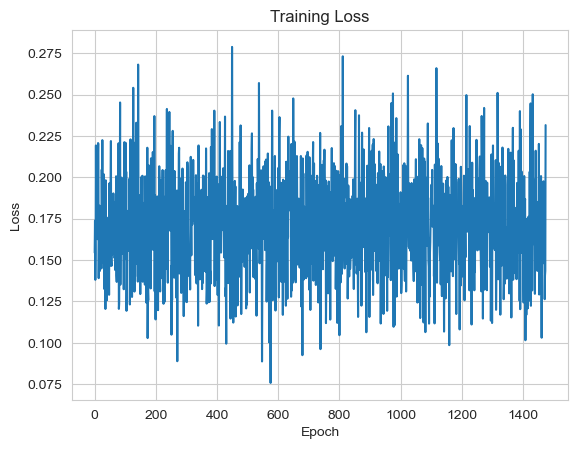

In [17]:
import matplotlib.pyplot as plt

losses = []
for epoch in range(epochs):
    for inputs, targets in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        losses.append(loss.item())

    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

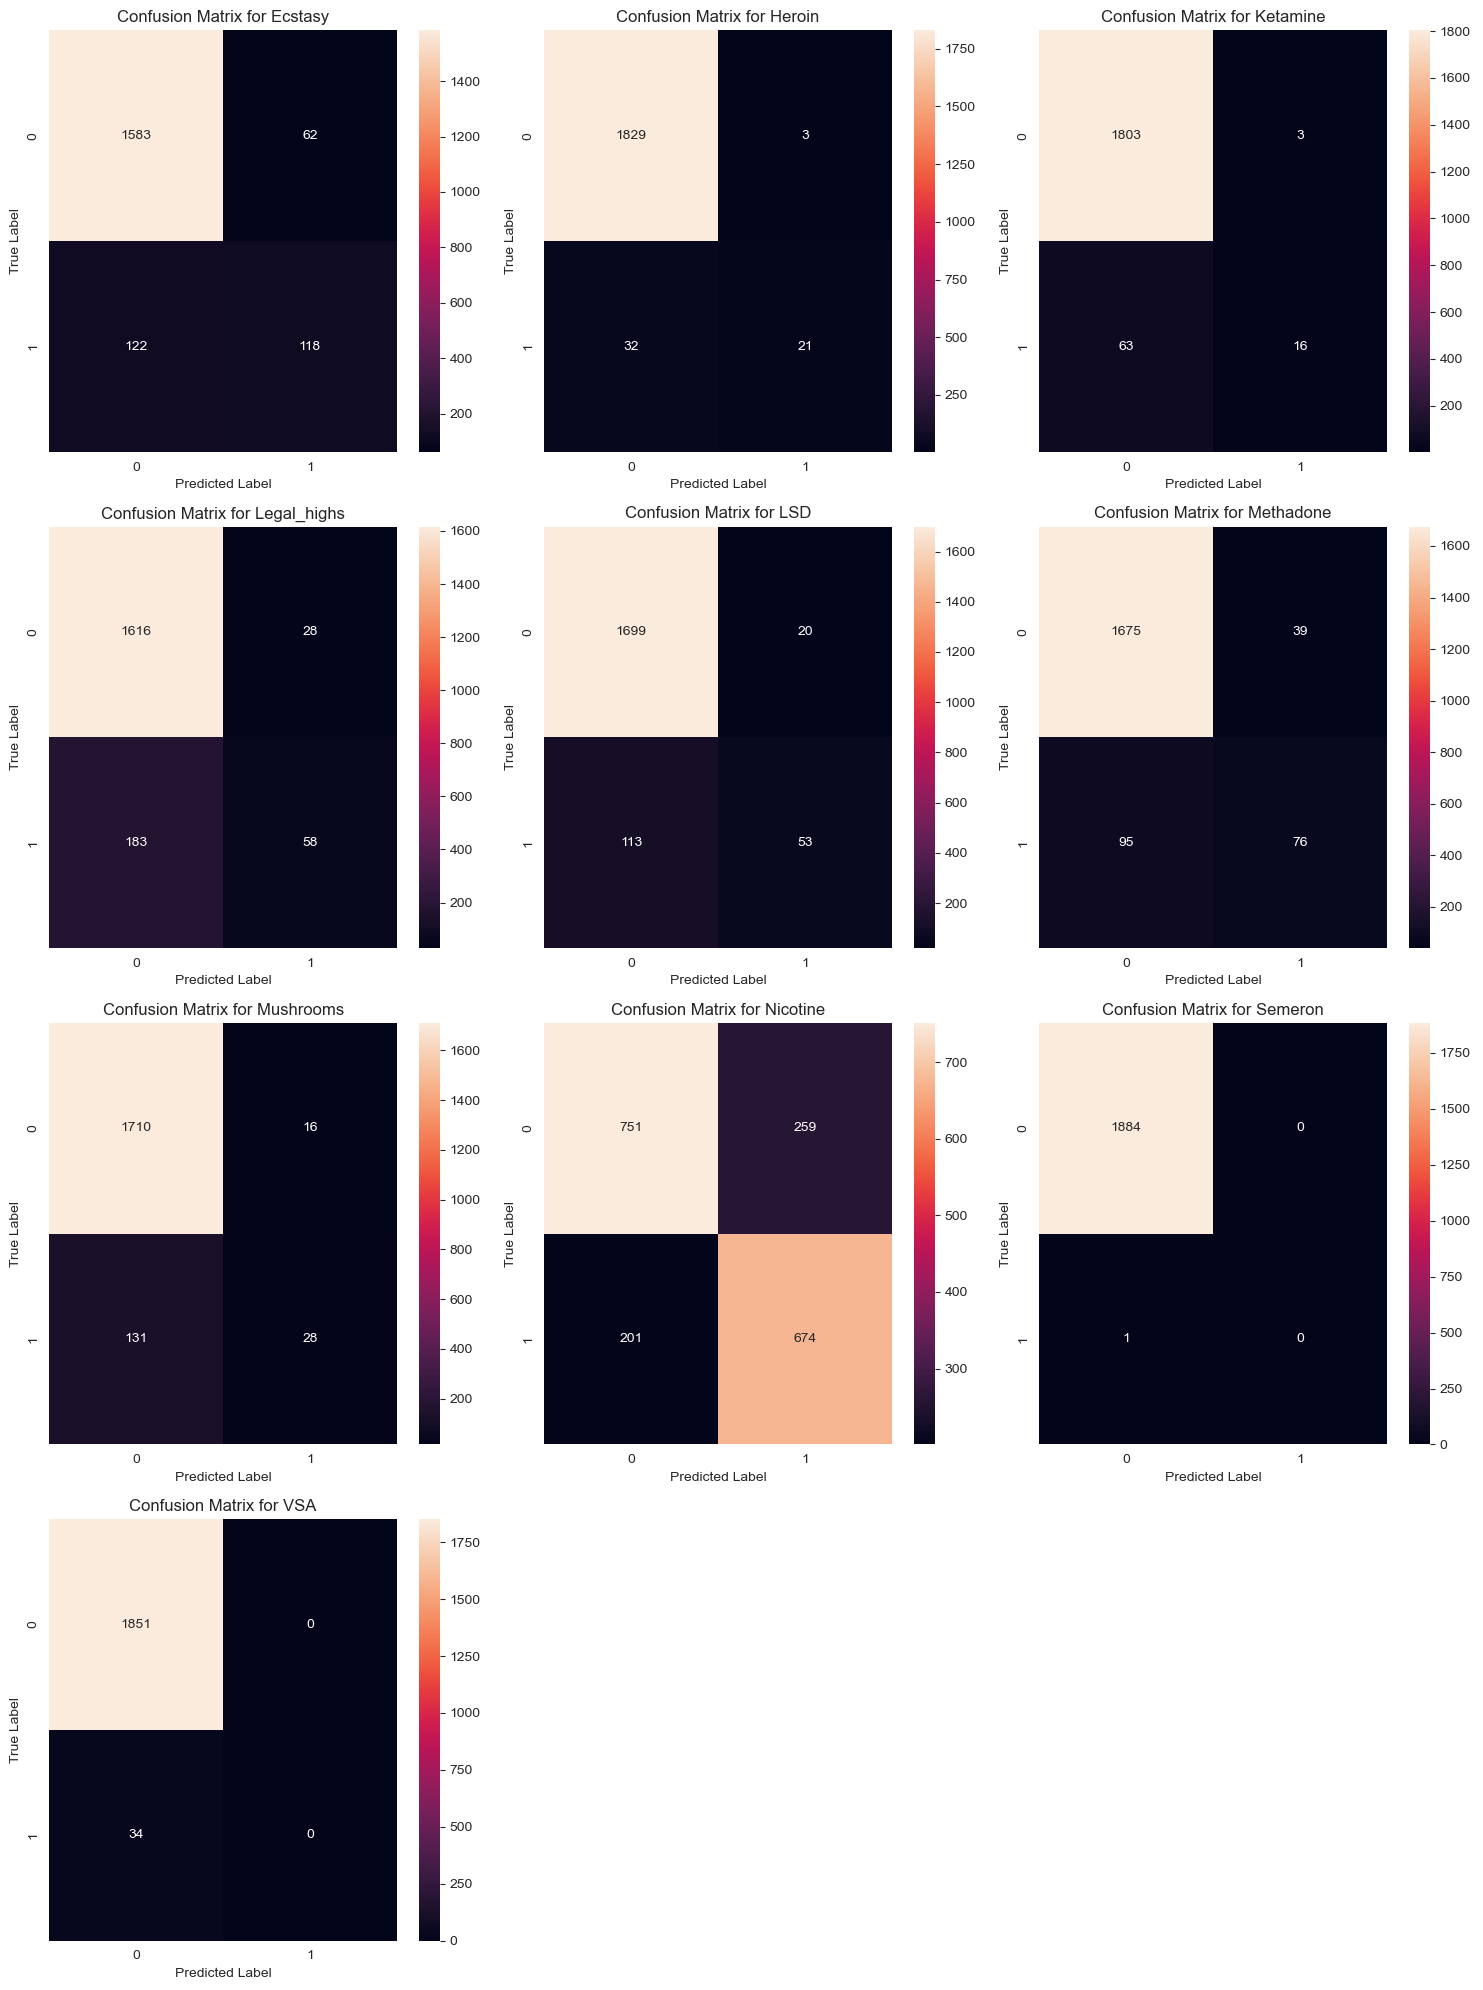

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

num_drugs = len(drug_columns)

num_rows = int(np.ceil(num_drugs / 3)) 
fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))

model.eval()  
with torch.no_grad():
    predictions = model(X_tensor)
    predicted_labels = predictions.round() 

for i, ax in enumerate(axes.flatten()):
    if i < num_drugs:
        true_labels = y_tensor[:, i]
        pred_labels = predicted_labels[:, i]
        cm = confusion_matrix(true_labels, pred_labels)
        sns.heatmap(cm, annot=True, fmt='d', ax=ax)
        ax.set_title(f'Confusion Matrix for {drug_columns[i]}')
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')
    else:
        ax.axis('off')  

plt.tight_layout()
plt.show()

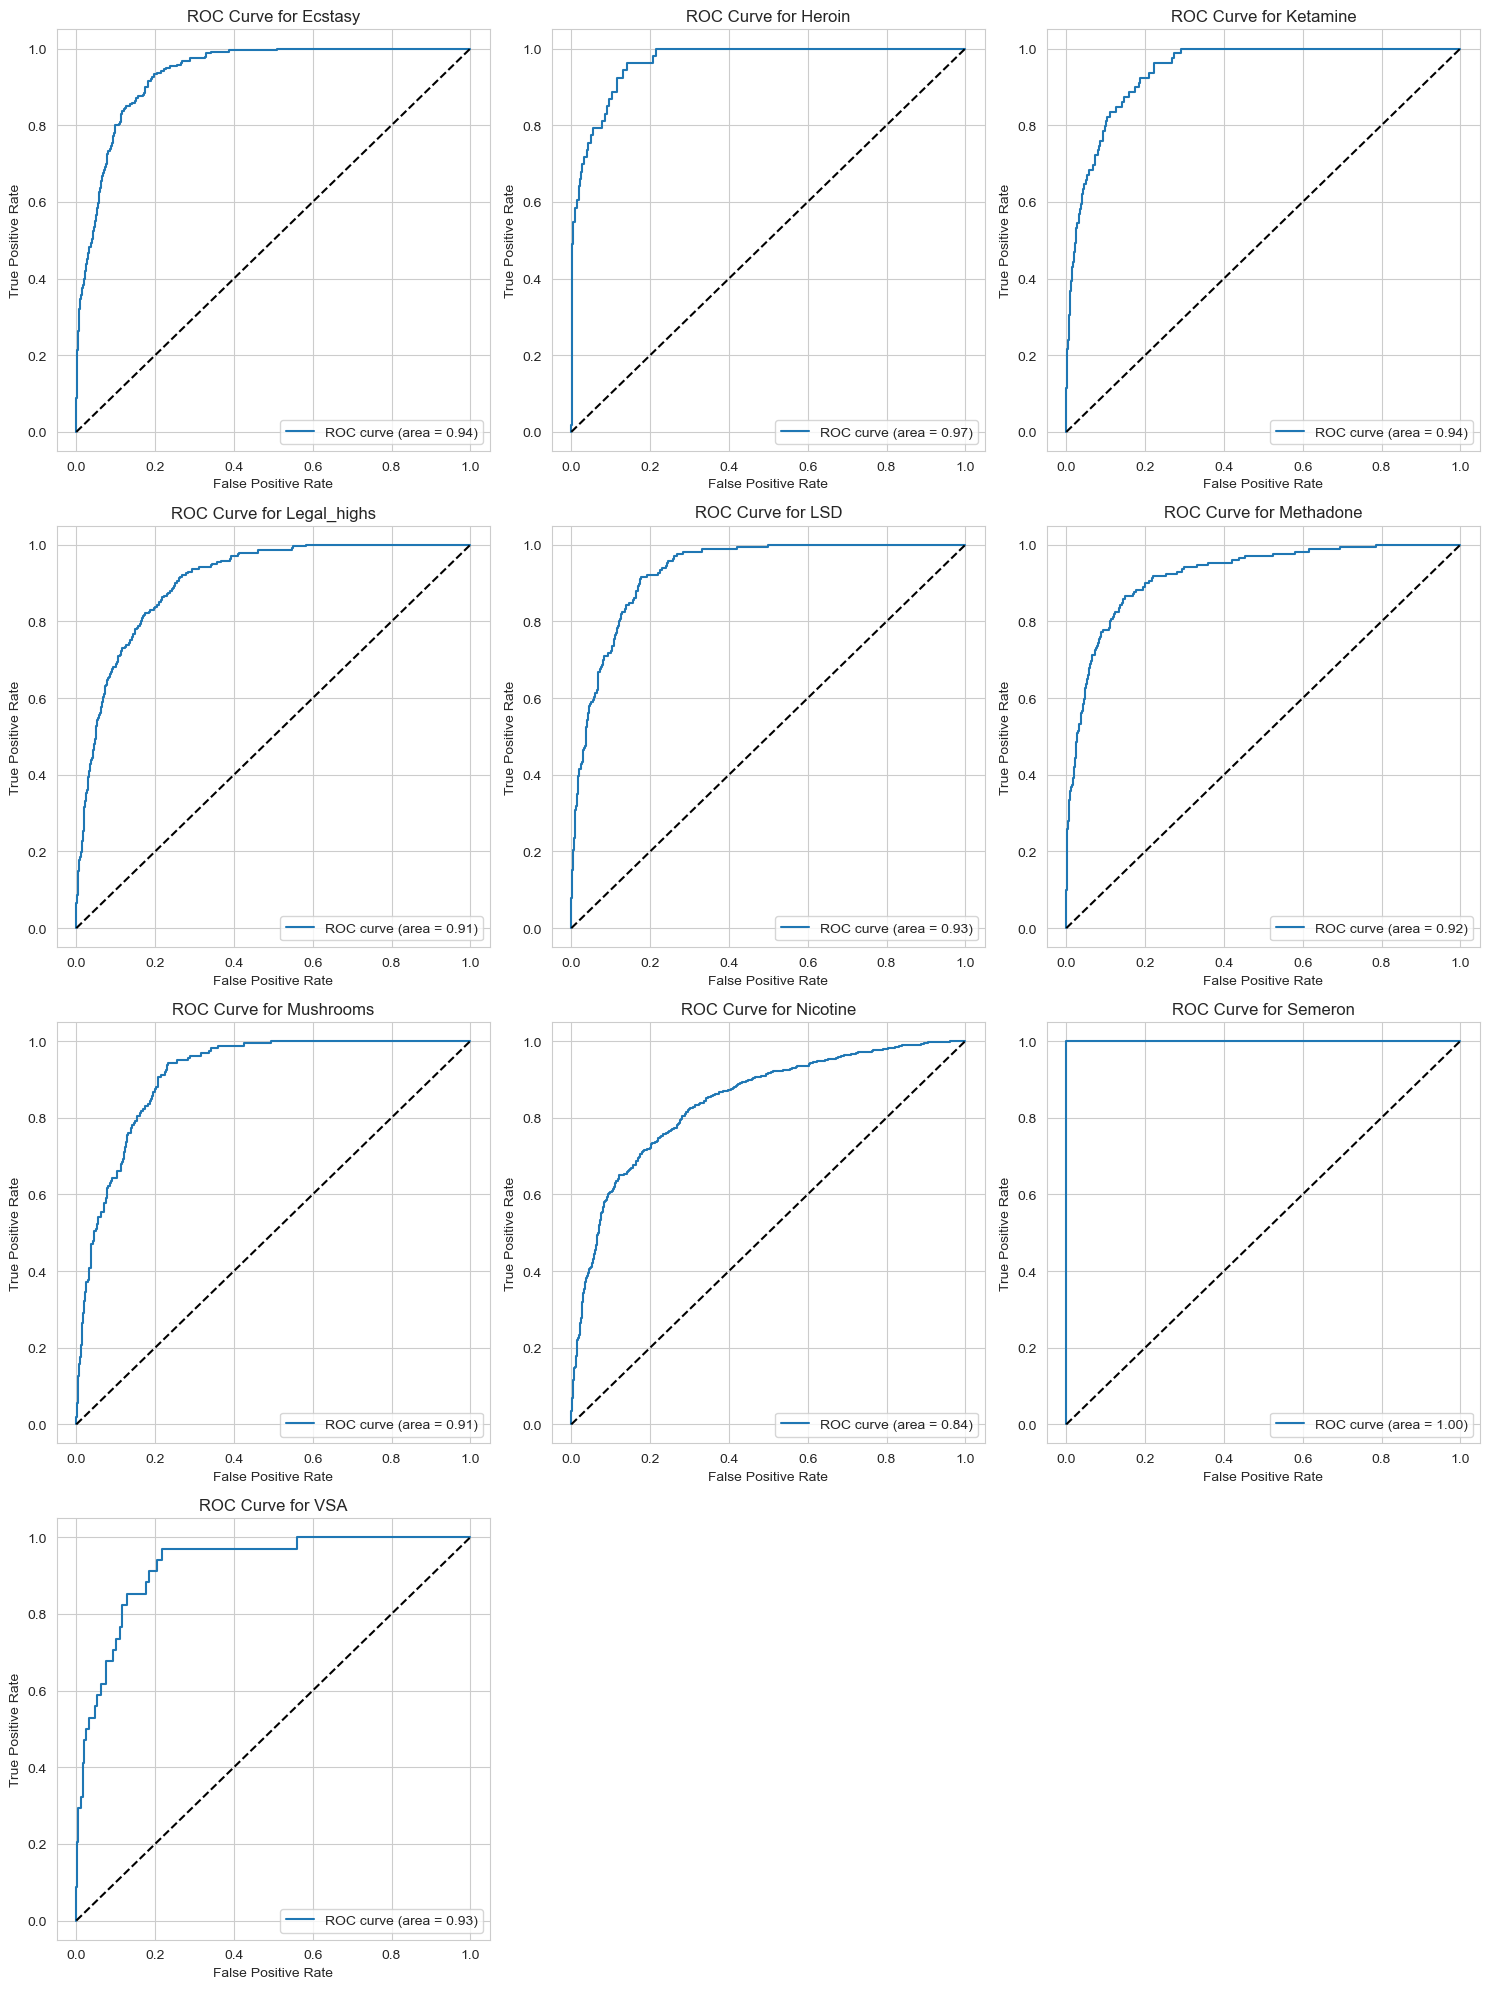

In [19]:
from sklearn.metrics import roc_curve, auc

fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))

for i, ax in enumerate(axes.flatten()):
    if i < num_drugs:
        true_labels = y_tensor[:, i]
        pred_probs = predictions[:, i]
        fpr, tpr, thresholds = roc_curve(true_labels, pred_probs)
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
        ax.plot([0, 1], [0, 1], 'k--') 
        ax.set_title(f'ROC Curve for {drug_columns[i]}')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend(loc="lower right")
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)


We will compare the following models:
1. Logistic Regression - A good baseline for classification problems.
2. Random Forest - An ensemble method known for its high accuracy.
3. Support Vector Machine (SVM) - Effective in high dimensional spaces.



Hyperparameters we will tune:
- Logistic Regression: Regularization strength (`C`)
- Random Forest: Number of trees (`n_estimators`) and max depth of trees (`max_depth`)
- SVM: Regularization parameter (`C`) and kernel type (`kernel`)


# Logistic Regression

In [21]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

model_to_tune = OneVsRestClassifier(LogisticRegression())
param_grid = {'estimator__C': [0.1, 1, 10, 100]} 

clf = GridSearchCV(model_to_tune, param_grid, cv=5)
clf.fit(X_train, y_train)

print("Best parameters:", clf.best_params_)
print("Best score:", clf.best_score_)

C:\Users\Aramis\anaconda3\Lib\site-packages\sklearn\multiclass.py:84: UserWarning:

Label not 8 is present in all training examples.

C:\Users\Aramis\anaconda3\Lib\site-packages\sklearn\multiclass.py:84: UserWarning:

Label not 8 is present in all training examples.

C:\Users\Aramis\anaconda3\Lib\site-packages\sklearn\multiclass.py:84: UserWarning:

Label not 8 is present in all training examples.

C:\Users\Aramis\anaconda3\Lib\site-packages\sklearn\multiclass.py:84: UserWarning:

Label not 8 is present in all training examples.



Best parameters: {'estimator__C': 0.1}
Best score: 0.4668610151591824


In [23]:

y_train_np = y_train.to_numpy() 
results = {}

for i, drug in enumerate(drug_columns):
    clf = GridSearchCV(LogisticRegression(max_iter = 1000), {'C': [0.1, 1, 10, 100]}, cv=5)
    clf.fit(X_train, y_train_np[:, i])  
    results[drug] = {
        'best_params': clf.best_params_,
        'best_score': clf.best_score_
    }

for drug, res in results.items():
    print(f"{drug}: Best Score - {res['best_score']}, Best Params - {res['best_params']}")

C:\Users\Aramis\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

C:\Users\Aramis\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning:


4 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Aramis\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Aramis\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *arg

Ecstasy: Best Score - 0.8693604101119888, Best Params - {'C': 0.1}
Heroin: Best Score - 0.9741413830278762, Best Params - {'C': 0.1}
Ketamine: Best Score - 0.9615365998547887, Best Params - {'C': 0.1}
Legal_highs: Best Score - 0.8826252447690921, Best Params - {'C': 0.1}
LSD: Best Score - 0.9091549140832985, Best Params - {'C': 0.1}
Methadone: Best Score - 0.9078260104288134, Best Params - {'C': 0.1}
Mushrooms: Best Score - 0.9190974896041892, Best Params - {'C': 0.1}
Nicotine: Best Score - 0.7062506875536292, Best Params - {'C': 0.1}
Semeron: Best Score - nan, Best Params - {'C': 0.1}
VSA: Best Score - 0.9840861587203802, Best Params - {'C': 0.1}


In [24]:

encoder = OneHotEncoder()
X_categorical_encoded = encoder.fit_transform(X[categorical_cols]).toarray()


X_processed = np.concatenate([X_numeric_scaled, X_categorical_encoded], axis=1)


X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)


subset_size = 0.3
X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, test_size=1-subset_size, random_state=42)
X_test_subset, _, y_test_subset, _ = train_test_split(X_test, y_test, test_size=1-subset_size, random_state=42)


y_train_subset = y_train_subset.to_numpy()
y_test_subset = y_test_subset.to_numpy()



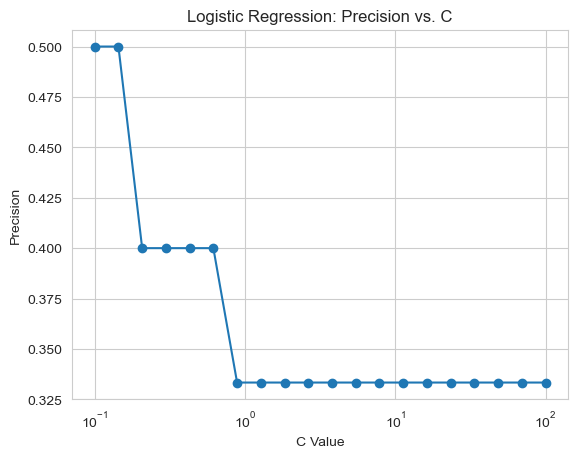

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
import numpy as np
import matplotlib.pyplot as plt

C_values = np.logspace(-1, 2, 20) 
precisions = []

for C in C_values:
    model = LogisticRegression(C=C, max_iter=500)
    model.fit(X_train_subset, y_train_subset[:, 0])
    predictions = model.predict(X_test_subset)
    precision = precision_score(y_test_subset[:, 0], predictions, zero_division=0)
    precisions.append(precision)

plt.plot(C_values, precisions, marker='o')
plt.xlabel('C Value')
plt.ylabel('Precision')
plt.title('Logistic Regression: Precision vs. C')
plt.xscale('log')
plt.show()


The output from the Logistic Regression model suggests varied performance across different drugs. Notably, drugs like 'Heroin', 'Ketamine', and 'VSA' achieve high scores, indicating effective predictive capability. Conversely, drugs such as 'Ecstasy' and 'Nicotine' yield lower scores, suggesting a more complex relationship with the features or a less distinct usage pattern. The variation in the optimal regularization strength (C) further highlights the unique nature of each drug's relationship with the predictors.

Key Takeaways:

Performance Variation: The model's effectiveness varies significantly across different drugs.
Regularization Strength: Optimal C values differ for each drug, underlining the need for tailored model configurations.
Data Specificity: The results emphasize the importance of considering each drug independently due to varying influences on usage patterns.

# Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier

rf_params = {'n_estimators': [10, 50, 100], 'max_depth': [None, 5, 10]}
rf_results = {}

for i, drug in enumerate(drug_columns):
    clf = GridSearchCV(RandomForestClassifier(), rf_params, cv=5)
    clf.fit(X_train, y_train_np[:, i])
    rf_results[drug] = {
        'best_params': clf.best_params_,
        'best_score': clf.best_score_
    }

for drug, res in rf_results.items():
    print(f"{drug} - RF: Best Score - {res['best_score']}, Best Params - {res['best_params']}")

C:\Users\Aramis\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



Ecstasy - RF: Best Score - 0.8733383203889904, Best Params - {'max_depth': 5, 'n_estimators': 10}
Heroin - RF: Best Score - 0.972812479373391, Best Params - {'max_depth': 5, 'n_estimators': 10}
Ketamine - RF: Best Score - 0.9608765483707729, Best Params - {'max_depth': None, 'n_estimators': 50}
Legal_highs - RF: Best Score - 0.8766583793535896, Best Params - {'max_depth': None, 'n_estimators': 100}
LSD - RF: Best Score - 0.9124683725330576, Best Params - {'max_depth': 10, 'n_estimators': 50}
Methadone - RF: Best Score - 0.909819365910541, Best Params - {'max_depth': 5, 'n_estimators': 10}
Mushrooms - RF: Best Score - 0.9204263932586743, Best Params - {'max_depth': 10, 'n_estimators': 50}
Nicotine - RF: Best Score - 0.7115641019999559, Best Params - {'max_depth': 5, 'n_estimators': 100}
Semeron - RF: Best Score - 0.9993377483443708, Best Params - {'max_depth': None, 'n_estimators': 10}
VSA - RF: Best Score - 0.9840861587203802, Best Params - {'max_depth': None, 'n_estimators': 10}


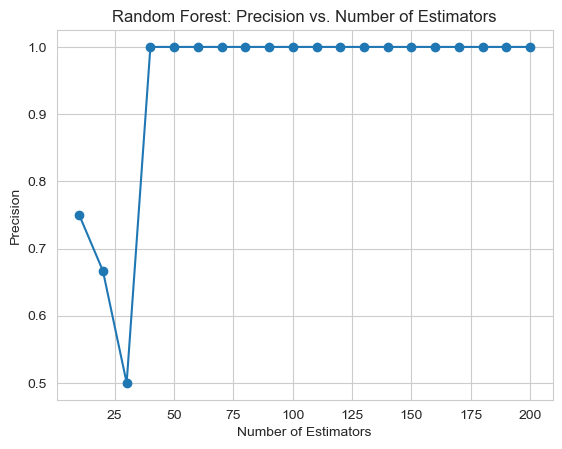

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
import numpy as np

n_estimators_values = np.arange(10, 210, 10)
rf_precisions = []

for n_estimators in n_estimators_values:
    rf_model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rf_model.fit(X_train_subset, y_train_subset[:, 0])
    predictions = rf_model.predict(X_test_subset)
    precision = precision_score(y_test_subset[:, 0], predictions, zero_division=0)
    rf_precisions.append(precision)

plt.plot(n_estimators_values, rf_precisions, marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Precision')
plt.title('Random Forest: Precision vs. Number of Estimators')
plt.show()


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 1, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]], dtype=int64)

The Random Forest model, known for its robustness and ability to handle complex interactions, also shows variability in performance across different drugs. This model performs exceptionally well for drugs like 'Heroin', 'VSA', and 'Mushrooms', while showing moderate performance for others like 'Nicotine'. The variation in the best parameters (n_estimators and max_depth) across different drugs reinforces the idea that each drug's usage pattern is influenced by different factors.

Key Observations:

High Accuracy for Certain Drugs: 'Heroin', 'VSA', and 'Mushrooms' show notably high prediction accuracy.
Parameter Variation: The best parameters for Random Forest vary, indicating the model's adaptability to different data structures.
Model Robustness: Random Forest's ability to capture complex patterns is evident in its generally high scores.

# Support Vector Machine

In [28]:
from sklearn.svm import SVC

svm_params = {'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear']}
svm_results = {}

for i, drug in enumerate(drug_columns):
    clf = GridSearchCV(SVC(), svm_params, cv=5)
    clf.fit(X_train, y_train_np[:, i])
    svm_results[drug] = {
        'best_params': clf.best_params_,
        'best_score': clf.best_score_
    }

for drug, res in svm_results.items():
    print(f"{drug} - SVM: Best Score - {res['best_score']}, Best Params - {res['best_params']}")

C:\Users\Aramis\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

C:\Users\Aramis\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning:


6 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Aramis\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Aramis\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *arg

Ecstasy - SVM: Best Score - 0.8779740819783944, Best Params - {'C': 1, 'kernel': 'rbf'}
Heroin - SVM: Best Score - 0.972812479373391, Best Params - {'C': 0.1, 'kernel': 'rbf'}
Ketamine - SVM: Best Score - 0.9608765483707729, Best Params - {'C': 0.1, 'kernel': 'rbf'}
Legal_highs - SVM: Best Score - 0.8740049723878462, Best Params - {'C': 0.1, 'kernel': 'rbf'}
LSD - SVM: Best Score - 0.9118061208774284, Best Params - {'C': 0.1, 'kernel': 'rbf'}
Methadone - SVM: Best Score - 0.9098149655673142, Best Params - {'C': 0.1, 'kernel': 'rbf'}
Mushrooms - SVM: Best Score - 0.9197619414314318, Best Params - {'C': 0.1, 'kernel': 'rbf'}
Nicotine - SVM: Best Score - 0.7088974940045324, Best Params - {'C': 1, 'kernel': 'rbf'}
Semeron - SVM: Best Score - nan, Best Params - {'C': 0.1, 'kernel': 'rbf'}
VSA - SVM: Best Score - 0.9840861587203802, Best Params - {'C': 0.1, 'kernel': 'rbf'}


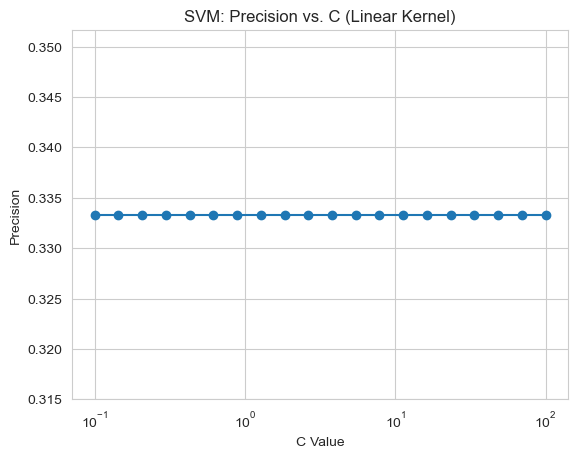

In [29]:
from sklearn.svm import SVC

C_values_svm = np.logspace(-1, 2, 20)  
svm_precisions = []

for C in C_values_svm:
    svm_model = SVC(C=C, kernel='linear', random_state=42) 
    svm_model.fit(X_train_subset, y_train_subset[:, 0])
    predictions = svm_model.predict(X_test_subset)
    precision = precision_score(y_test_subset[:, 0], predictions, zero_division=0)
    svm_precisions.append(precision)

plt.plot(C_values_svm, svm_precisions, marker='o')
plt.xlabel('C Value')
plt.ylabel('Precision')
plt.title('SVM: Precision vs. C (Linear Kernel)')
plt.xscale('log')
plt.show()

The SVM model, effective in high-dimensional spaces, displays a mixed performance similar to the previous models. It achieves high accuracy for drugs like 'Heroin' and 'VSA', while other drugs show varied results. The choice of kernel and C value differs across drugs, indicating the need for specific tuning for each drug's prediction.

Insights:

Effective High-Dimensional Learning: The SVM model works well for certain drugs, especially where linear separability might be present (as indicated by the success of the 'linear' kernel in some cases).
Kernel and Regularization: The choice of kernel and C value significantly impacts model performance, requiring careful tuning for each drug.
Balanced Performance: While not always achieving the highest scores, SVM provides a balanced performance across different drugs.
In summary, the comparison of Logistic Regression, Random Forest, and SVM models on this multi-label drug consumption dataset reveals significant variations in performance across different drugs. Each model has its strengths and is better suited for predicting certain drugs over others. The analysis suggests the necessity of a tailored approach for each drug, considering the unique patterns and relationships within the data.

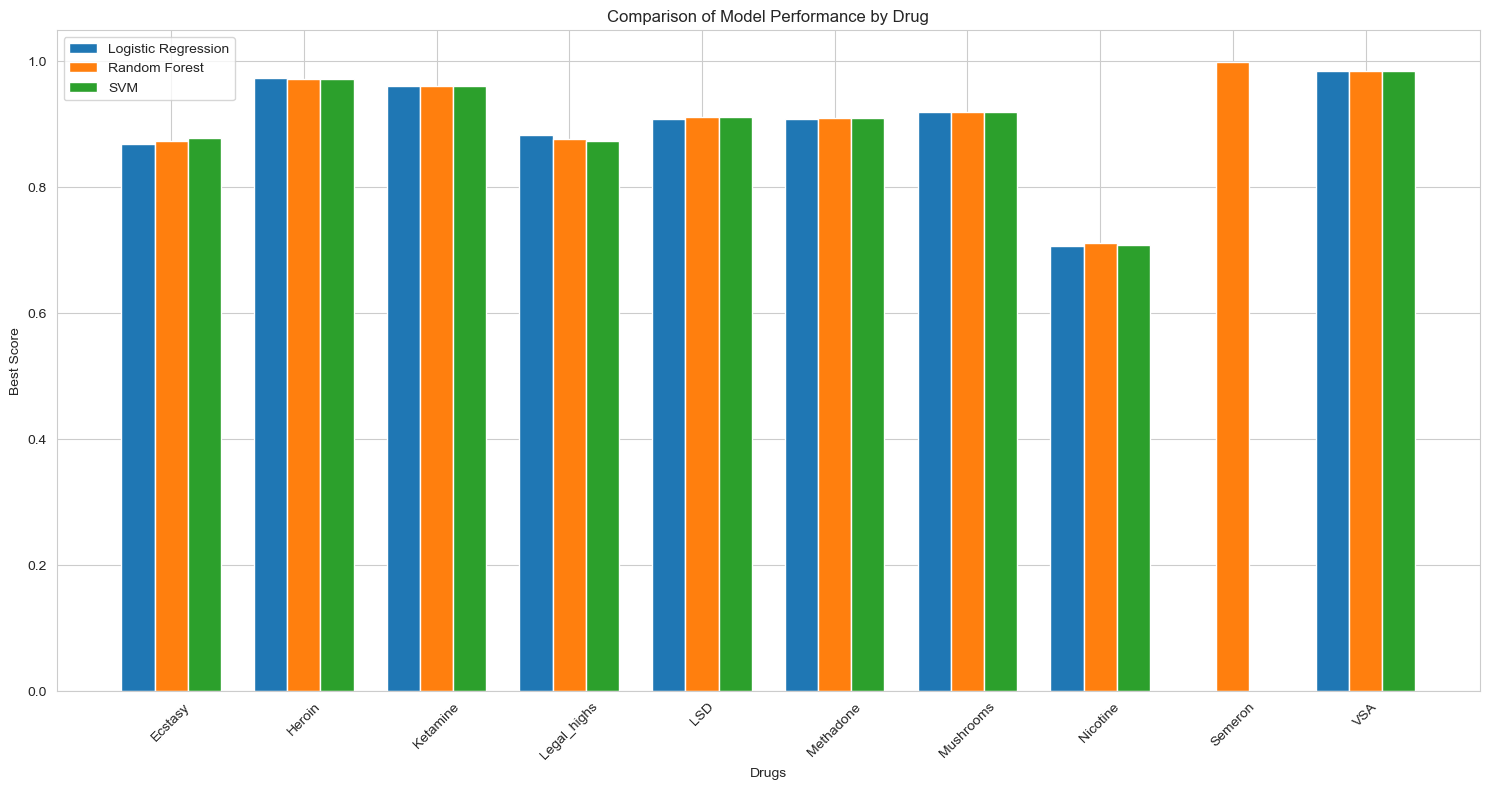

In [30]:
import matplotlib.pyplot as plt
import numpy as np

drugs = list(drug_columns)
scores_lr = [results[drug]['best_score'] for drug in drugs]
scores_rf = [rf_results[drug]['best_score'] for drug in drugs]
scores_svm = [svm_results[drug]['best_score'] for drug in drugs]

bar_width = 0.25
index = np.arange(len(drugs))

plt.figure(figsize=(15, 8))

plt.bar(index, scores_lr, bar_width, label='Logistic Regression')
plt.bar(index + bar_width, scores_rf, bar_width, label='Random Forest')
plt.bar(index + 2*bar_width, scores_svm, bar_width, label='SVM')

plt.xlabel('Drugs')
plt.ylabel('Best Score')
plt.title('Comparison of Model Performance by Drug')
plt.xticks(index + bar_width, drugs, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

In [87]:
colors = {
    'background': '#111111',
    'text': '#7FDBFF'
}
def generate_table(dataframe, max_rows=10):
    # dataframe=dataframe.iloc[4:max_rows, 12:]
    # dataframe=dataframe.applymap(lambda i:traduction[i])
    return html.Div(
        style={'overflow-x': 'auto'},  # Ajout de la barre de défilement horizontale
        children=[
            html.Table(
                style={
                    'width': '80%',
                    'margin': 'auto',
                    'background-color': colors['background'],
                    'color': colors['text']
                },
                children=[
                    html.Thead(
                        html.Tr([html.Th(col) for col in dataframe.columns])
                    ),
                    html.Tbody([
                        html.Tr([
                            html.Td(dataframe.iloc[i][col]) for col in dataframe.columns
                        ]) for i in range(min(len(dataframe), max_rows))
                    ])
                ]
            )
        ]
    )
X=df[['Age', 'Neuroticism','Extraversion', 'Openness', 'Agreeableness', 'Conscientiousness','Impulsiveness', 'Sensation_seeking']]
Y=df[['Alcohol', 'Cannabis','Cocaine', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine', 'Mushrooms']].applymap(lambda i :change(i))
rf_model = RandomForestClassifier(n_estimators=50, random_state=42)
rf_model.fit(X.values ,Y.values)

In [120]:
app = Dash(__name__)
external_stylesheets = [dbc.themes.CERULEAN]
app = Dash(__name__, external_stylesheets=external_stylesheets)
# App layout
app.layout = dbc.Container(children=[
    html.H1(
        children="Web Application Dashboards with Dash",
        style={'background-color': colors['background'],
        'color': colors['text']}
        ),

    dcc.Dropdown(id="slct_column",
                 options = [{"label": i, "value" :i} for i in df.columns],
                 multi=False,
                 value="Age",
                 style={
                'background-color': colors['background'],
                'color': colors['text'],
                'border': f'1px solid {colors["text"]}'  # Ajoute une bordure pour mieux distinguer le menu déroulant
    }
                 ),
    html.Br(), #espace
    dcc.Graph(id='count plot mgl', figure={}),
    dcc.Graph(id='covariance', figure={}),
    
    dbc.Row([html.P("Age"),
             dcc.Slider(0, 100, 5, value=50, id='age'),
             html.P("Neuroticism"),
             dcc.Slider(-3, 3, 0.3, value=0, id='Neuroticism'),
             html.P("Extraversion"),
             dcc.Slider(-3, 3, 0.3, value=0, id='Extraversion'),
             html.P("Openness"),
             dcc.Slider(-3, 3, 0.3, value=0, id='Openness'),
             html.P("Conscientiousness"),
             dcc.Slider(-3, 3, 0.3, value=0, id='Agreeableness'),
             html.P("Neuroticism"),
             dcc.Slider(-3, 3, 0.3, value=0, id='Conscientiousness'),
             html.P("Impulsiveness"),
             dcc.Slider(-3, 3, 0.3, value=0, id='Impulsiveness'),
             html.P("Sensation_seeking"),
             dcc.Slider(-2, 2, 0.2, value=0, id='Sensation_seeking')
    ]),
    html.Table([
        html.Tr([html.Th('Slider'), html.Th('Position')]),
        html.Tr([html.Td('Alcohol'), html.Td(id='slider1-output')]),
        html.Tr([html.Td('Cannabis'), html.Td(id='slider2-output')]),
        html.Tr([html.Td('Cocaine'), html.Td(id='slider3-output')]),
        html.Tr([html.Td('Crack'), html.Td(id='slider4-output')]),
        html.Tr([html.Td('Ecstasy'), html.Td(id='slider5-output')]),
        html.Tr([html.Td('Heroin'), html.Td(id='slider6-output')]),
        html.Tr([html.Td('Ketamine'), html.Td(id='slider7-output')]),
        html.Tr([html.Td('Mushrooms'), html.Td(id='slider8-output')])
    ]),
    html.H4(children='Affichage du dataset', style={
    'background-color': colors['background'],
    'color': colors['text']}),
    generate_table(df)
],style={'background-color': colors['background'], 'color': colors['text']})

In [121]:
# Connect the Plotly graphs with Dash Components
@app.callback( #sous chaque callback, il y a une fonction update_graph, qui adapte le graph en fonction de l'imput
    [Output(component_id='count plot mgl', component_property='figure')],
    [Input(component_id='slct_column', component_property='value')]
)
def update_graph(option_slctd):
    print(option_slctd)
    print(type(option_slctd))

    container = "The year chosen by user was: {}".format(option_slctd)
    
    dff = df.replace(traduction)

    # Plotly Express
    order = ["Never Used", "Used over a Decade Ago", "Used in Last Decade", "Used in Last Year", "Used in Last Month", "Used in Last Week", "Used in Last Day"]
    fig = px.histogram(dff, x=option_slctd, title=f'Comptage des valeurs pour la colonne {option_slctd}',
                   category_orders={option_slctd: order})
    fig.update_layout(
    plot_bgcolor=colors['background'],
    paper_bgcolor=colors['background'],
    font_color=colors['text']
)
    return (fig,)

@app.callback( #sous chaque callback, il y a une fonction update_graph, qui adapte le graph en fonction de l'imput
    [Output(component_id='covariance', component_property='figure')],
    [Input(component_id='slct_column', component_property='value')]
)
def update_graph(col_selected):
    dff=df.copy().iloc[:,:12]
    dff[col_selected]=df[col_selected].apply(lambda x: change(x)) #convertion en entier (consomme ou pas)
    dff[col_selected] = (dff[col_selected]-dff[col_selected].mean())/dff[col_selected].std() #normalisation
    covariances = dff.cov()[col_selected].sort_values()
    
    covariances=covariances.drop(col_selected)
    #covariances=covariances.drop('ID')
    data = {'Columns': covariances.index, 'Covariance': covariances.values}
    covariances = pd.DataFrame(data)


    fig = px.bar(covariances, y='Columns', x='Covariance', title=f'Covariances avec {col_selected}')
    fig.update_layout(
    plot_bgcolor=colors['background'],
    paper_bgcolor=colors['background'],
    font_color=colors['text']
    )
    return (fig,)
@app.callback(
    [Output('slider1-output', 'children'),
     Output('slider2-output', 'children'),
     Output('slider3-output', 'children'),
     Output('slider4-output', 'children'),
     Output('slider5-output', 'children'),
     Output('slider6-output', 'children'),
     Output('slider7-output', 'children'),
     Output('slider8-output', 'children')],
    [Input('age', 'value'),
     Input('Neuroticism', 'value'),
     Input('Extraversion', 'value'),
     Input('Openness', 'value'),
     Input('Agreeableness', 'value'),
     Input('Conscientiousness', 'value'),
     Input('Impulsiveness', 'value'),
     Input('Sensation_seeking', 'value')]
)
def update_table(slider1, slider2, slider3, slider4, slider5, slider6, slider7, slider8):
    #return slider1, slider2, slider3, slider4, slider5, slider6, slider7, slider8
    test=np.array([slider1, slider2, slider3, slider4, slider5, slider6, slider7, slider8])
    return tuple(i[0,1] for i in rf_model.predict_proba(test.reshape(1, -1)))
    

#http://127.0.0.1:8050/
# ------------------------------------------------------------------------------
if __name__ == '__main__':
    app.run_server(debug=True)